In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back),0]
		dataX.append(a)
		dataY.append(dataset[i + look_back,0])
	return numpy.array(dataX), numpy.array(dataY)

In [4]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('./data/data_per_day.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [5]:
dataset.shape

(598, 1)

In [6]:
diff_set = numpy.diff(dataset.T, n=1)
diff_set = diff_set.T
#diff_set
diff_set.shape

(597, 1)

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
early_stop = [EarlyStopping(monitor='loss', patience=30, mode='auto', min_delta=0.0005)]
model.fit(trainX, trainY, epochs=150, batch_size=10, verbose=2, callbacks=early_stop)

Epoch 1/150
 - 2s - loss: 0.5539
Epoch 2/150
 - 1s - loss: 0.1110
Epoch 3/150
 - 1s - loss: 0.0144
Epoch 4/150
 - 1s - loss: 0.0137
Epoch 5/150
 - 1s - loss: 0.0135
Epoch 6/150
 - 1s - loss: 0.0136
Epoch 7/150
 - 1s - loss: 0.0136
Epoch 8/150
 - 1s - loss: 0.0134
Epoch 9/150
 - 1s - loss: 0.0135
Epoch 10/150
 - 1s - loss: 0.0132
Epoch 11/150
 - 1s - loss: 0.0135
Epoch 12/150
 - 1s - loss: 0.0134
Epoch 13/150
 - 1s - loss: 0.0132
Epoch 14/150
 - 1s - loss: 0.0133
Epoch 15/150
 - 1s - loss: 0.0134
Epoch 16/150
 - 1s - loss: 0.0132
Epoch 17/150
 - 1s - loss: 0.0133
Epoch 18/150
 - 1s - loss: 0.0134
Epoch 19/150
 - 1s - loss: 0.0132
Epoch 20/150
 - 1s - loss: 0.0131
Epoch 21/150
 - 1s - loss: 0.0131
Epoch 22/150
 - 1s - loss: 0.0131
Epoch 23/150
 - 1s - loss: 0.0133
Epoch 24/150
 - 1s - loss: 0.0132
Epoch 25/150
 - 1s - loss: 0.0131
Epoch 26/150
 - 1s - loss: 0.0131
Epoch 27/150
 - 1s - loss: 0.0133
Epoch 28/150
 - 1s - loss: 0.0133
Epoch 29/150
 - 1s - loss: 0.0132
Epoch 30/150
 - 1s - lo

Train Score: 13.67 RMSE
Test Score: 13.98 RMSE


Text(0, 0.5, 'Venda Normalizada')

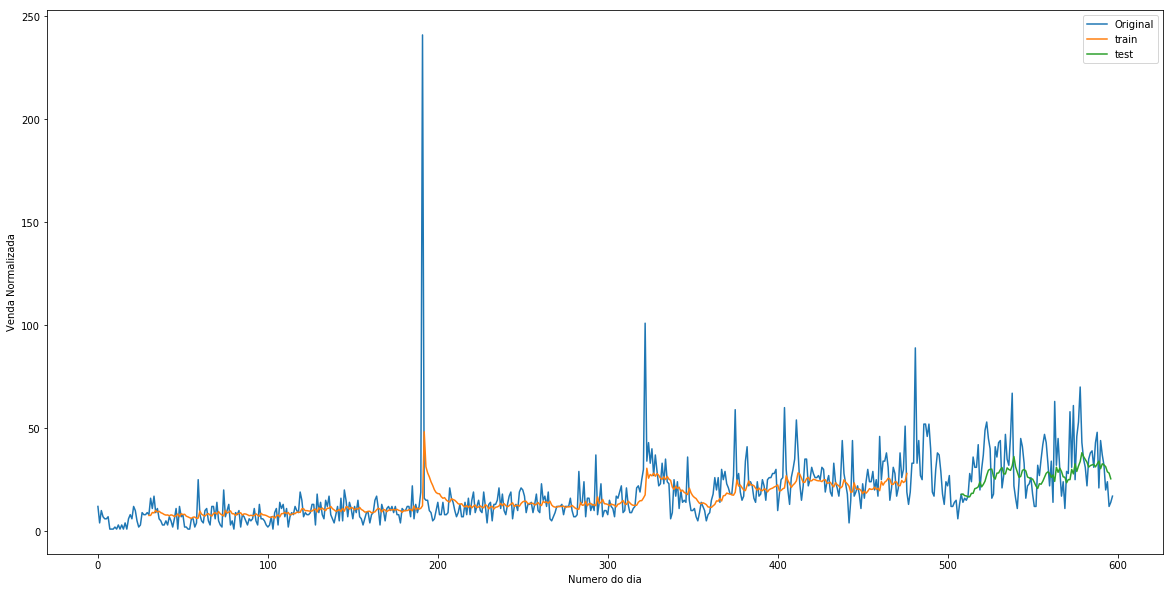

In [8]:
# make predictions
trainPredict = model.predict(trainX, batch_size=6)
testPredict = model.predict(testX, batch_size=6)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY,])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Original','train','test'])
plt.xlabel('Numero do dia')
plt.ylabel('Venda Normalizada')

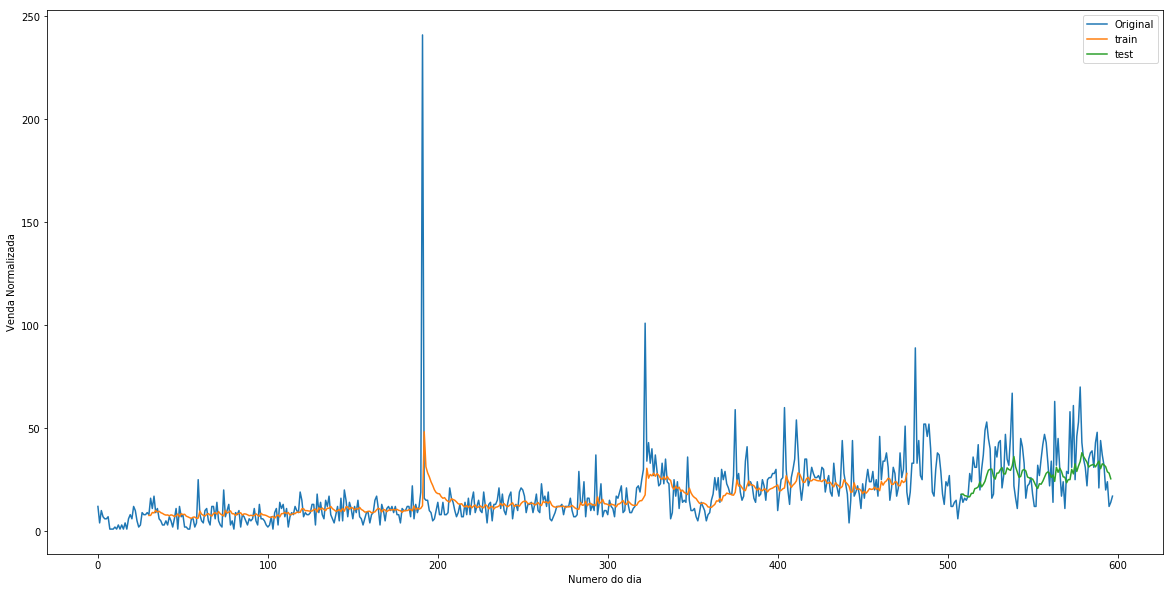

In [9]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Original','train','test'])
plt.xlabel('Numero do dia')
plt.ylabel('Venda Normalizada')
plt.savefig('./LSTM_1camada_Janela30.png')